In [2]:
import matplotlib.pyplot as plt
import math
import numpy as np
from sklearn.utils import shuffle
import pandas as pd
import os
import seaborn as sns
import cv2
from ast import literal_eval
from sklearn.model_selection import train_test_split
from ast import literal_eval
from PIL import Image

In [3]:
# Please update the directories based on the data directory path on your local machine.
img_dir  = '/media/sophie/SDD_Data/Data/cats_and_dogs/data/'
ann = '/media/sophie/SDD_Data/Data/cats_and_dogs/pets_dataset_info.csv'

In [4]:
# loading annotation file
df= pd.read_csv(ann)
df.head()

,Sample_ID,Breed,PET_ID
0,e23e7fba-cdcf-59fc-b6e1-3dbae82c3f36,['samoyed'],[1]
1,bd3703af-9e60-5667-a6ca-e4f5a71e319b,['samoyed'],[2]
2,e1a0b2fa-5b34-565b-9f64-96704101804c,['keeshond'],[3]
3,dd9e09f2-8d78-5bcb-8873-d52c6ed83d1b,"['Persian', 'havanese']","[4, 5]"
4,a8d71823-ace8-5898-b017-209f9ef4cda9,['samoyed'],[6]


In [57]:
# label encoding
breed_class = {
    'Abyssinian': 0,
    'Bengal': 1,
    'Birman': 2,
    'Bombay': 3,
    'British_Shorthair': 4,
    'Egyptian_Mau': 5,
    'Maine_Coon': 6,
    'Persian': 7,
    'Ragdoll': 8,
    'Russian_Blue': 9,
    'Siamese': 10,
    'Sphynx': 11,
    'american_bulldog': 12,
    'american_pit_bull_terrier': 13,
    'basset_hound': 14,
    'beagle': 15,
    'boxer': 16,
    'chihuahua': 17,
    'english_cocker_spaniel': 18,
    'english_setter': 19,
    'german_shorthaired': 20,
    'great_pyrenees': 21,
    'havanese': 22,
    'japanese_chin': 23,
    'keeshond': 24,
    'leonberger': 25,
    'miniature_pinscher': 26,
    'newfoundland': 27,
    'pomeranian': 28,
    'pug': 29,
    'saint_bernard': 30,
    'samoyed': 31,
    'scottish_terrier': 32,
    'shiba_inu': 33,
    'staffordshire_bull_terrier': 34,
    'wheaten_terrier': 35,
    'yorkshire_terrier': 36
}


In [71]:
classes = {
    'cat': 0,
    'dog': 1,
    'both': 2
}

In [160]:
# assigning a unique numerical label to each "Breed" category, and creating "Cat", "Dog", "Both"
# column to be able to use it as  in the classifier.
category = []
breed_category = []
cats = [
    "Abyssinian", "Bengal", "Birman", "Bombay", "British_Shorthair",
    "Egyptian_Mau", "Maine_Coon", "Persian", "Ragdoll", "Russian_Blue",
    "Siamese", "Sphynx"
]

dogs = [
    "american_bulldog", "american_pit_bull_terrier", "basset_hound",
    "beagle", "boxer", "chihuahua", "english_cocker_spaniel",
    "english_setter", "german_shorthaired", "great_pyrenees",
    "havanese", "japanese_chin", "keeshond", "leonberger",
    "miniature_pinscher", "newfoundland", "pomeranian", "pug",
    "saint_bernard", "samoyed", "scottish_terrier", "shiba_inu",
    "staffordshire_bull_terrier", "wheaten_terrier", "yorkshire_terrier"
]

for index, row in df.iterrows():
    
    breed = literal_eval(row['Breed'])

    if len(breed) == 1 and all(name in cats for name in breed):
        category.append(0)
        breed_category.append([breed_class[breed[0]]])
    elif len(breed) == 1 and all(name in dogs for name in breed):
        category.append(1)
        breed_category.append(breed_class[breed[0]])
    elif len(breed) == 2 and all(name in (cats + dogs) for name in breed):
        category.append(2)
        tmp = [breed_class[b] for b in breed]
        breed_category.append(tmp)
    else:
        print('Unknown breed!')    

In [98]:
df['category'] = category
df['breed_category'] = breed_category
df.head()

,Sample_ID,Breed,PET_ID,category,breed_category
0,e23e7fba-cdcf-59fc-b6e1-3dbae82c3f36,['samoyed'],[1],1,[31]
1,bd3703af-9e60-5667-a6ca-e4f5a71e319b,['samoyed'],[2],1,[31]
2,e1a0b2fa-5b34-565b-9f64-96704101804c,['keeshond'],[3],1,[24]
3,dd9e09f2-8d78-5bcb-8873-d52c6ed83d1b,"['Persian', 'havanese']","[4, 5]",2,"[7, 22]"
4,a8d71823-ace8-5898-b017-209f9ef4cda9,['samoyed'],[6],1,[31]


## Data Analysis

Text(0.5, 1.0, 'Class distribution in dataset')

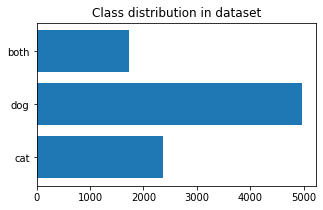

In [108]:
# Check class distribution. Do we have class imbalances
cat, counts = np.unique(df['category'], return_counts=True)
labels = list(classes.keys())
plt.rcParams["figure.figsize"] = (5,3)
plt.barh(labels, counts)
plt.title('Class distribution in dataset')

Text(0.5, 1.0, 'Class distribution in dataset')

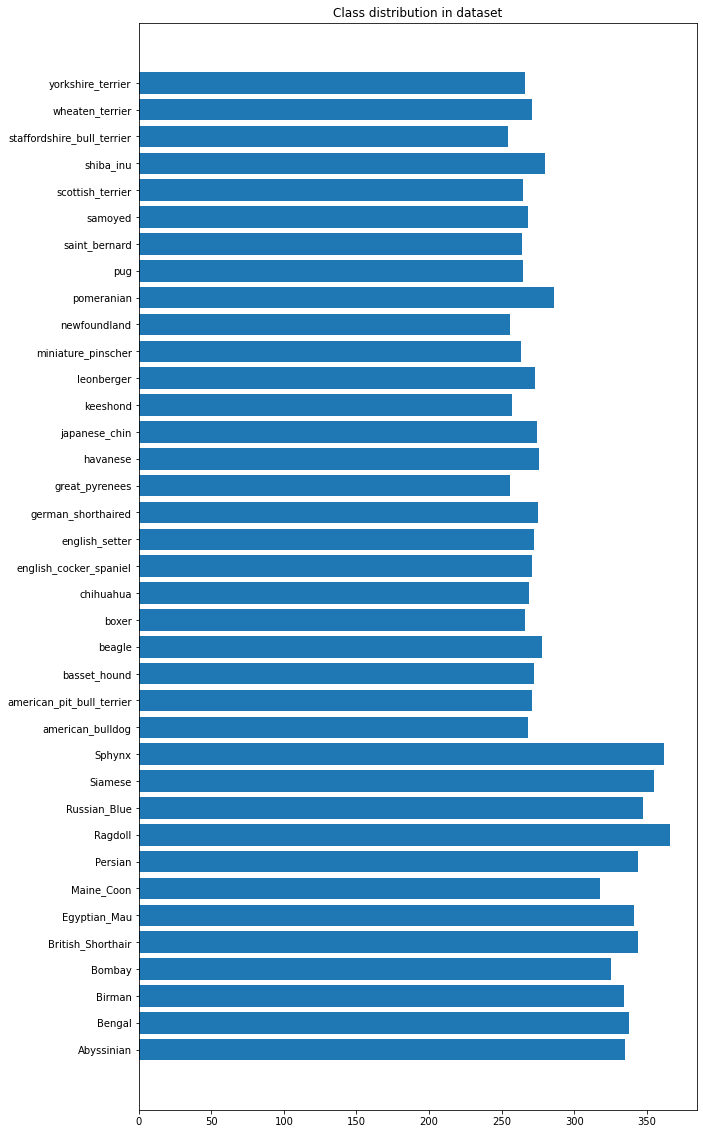

In [87]:
# visualising breed distribution 
breed_count = df['breed_category'].explode()
cat, counts = np.unique(breed_count, return_counts=True)
labels = list(breed_class.keys())
plt.rcParams["figure.figsize"] = (10,20)
plt.barh(labels, counts)
plt.title('Class distribution in dataset')

### Split the dataset to train, validate, and test sets
We need to have validation set to be able to validate our model during the training process. So the validation set is visible to the model during training. We need to split the test set to validation and unseen-test so that we can evaluate the model performance on data it has never seen before. In other words, we need to make sure the model can generalise its learnings to unseen data.

In [123]:
sample_id_train, sample_id_tmp, pet_id_train, pet_id_tmp, label_train, label_tmp, breed_label_train, breed_label_tmp = train_test_split(df['Sample_ID'], df['PET_ID'], df['category'], df['breed_category'], test_size=0.10, random_state=38)
                                                                              
sample_id_val, sample_id_test, pet_id_val, pet_id_test, label_val, label_test, breed_label_val, breed_label_test = train_test_split(sample_id_tmp, pet_id_tmp, label_tmp, breed_label_tmp, test_size=0.2, random_state=38)                                                                          

### convert train, validate, and test sets to dataframes and save them

In [124]:
dataset_train = pd.DataFrame({'id': sample_id_train, 'pet_id': pet_id_train, 'label': label_train, 'breed_label': breed_label_train})
dataset_valid = pd.DataFrame({'id': sample_id_val, 'pet_id': pet_id_val, 'label': label_val,   'breed_label': breed_label_val})
dataset_test  = pd.DataFrame({'id': sample_id_test, 'pet_id': pet_id_test, 'label': label_test,  'breed_label': breed_label_test})


In [125]:
dataset_train.head(10)

,id,pet_id,label,breed_label
6108,0c2aa3f7-699f-59e1-b43d-4d0a1ccf8a0d,[4474],0,[11]
2708,cf344b7a-5593-5a8b-9155-2481b2fe813a,[2884],1,[34]
3140,6cafc3ba-77d4-59bf-ab54-2a00a8adeffc,[3270],1,[17]
8744,23f6533e-ebc2-5596-be6b-d5bb087933b6,"[5163, 6652]",2,"[5, 12]"
8339,43879ab3-c4f3-5713-8176-9bcf800eb591,[6946],1,[25]
8200,df4d8366-819b-5f76-a2aa-12f01bbf6709,[6871],1,[23]
8425,d874d21c-0073-5647-8659-515840f0538f,[6991],1,[32]
1053,6653e96c-406e-579d-a794-a93e21a70013,"[541, 1206]",2,"[3, 19]"
280,7634d584-b244-5a34-8750-6487188772a5,[328],0,[5]
6018,408ac855-868c-55ea-bc60-366a9e73e5b8,[5506],1,[16]


In [126]:
print(dataset_train.shape)
print(dataset_valid.shape)
print(dataset_test.shape)

(8178, 4)
(727, 4)
(182, 4)


In [127]:
# We keep these for inference. In fact, we only need test dataset for inference
# to be able to test the end to end solution with unseen data. But it is good to keep train, validate, 
# and test datasets before we split 2-pet images in to two seperate image. See 
# below for detailed explanation
dataset_train.to_csv('inputs/csv/df_train.csv', index=False)
dataset_valid.to_csv('inputs/csv/df_val.csv', index=False)
dataset_test.to_csv('inputs/csv/df_test.csv', index=False)

### Handeling variable input length and design considerations
In this dataset, each image features one or two pets. This means there are two design choices in order to output segmentation and classification information:
- Use the position information of each pet in images (i.e. bounding box) and train an instant segmentation model like Mask R-CNN
- Design a preprocessing algorithm that split the images with two pets and creates two images when there are two pets in the image and build a multi-headed segmentation and classification algorithm.  

The dataset doesn't provide bounding box information and processing the images to obtain them is time consuming and may result in inaccurate position information. So the second design option is more appropriate for this task.


### Split two-pet images
- **Training**: During the training process, I utilize the breed classes to identify the two-pet images. These images are then split into two separate images and corresponding masks. I don't employ the method presented for inference to avoid introducing additional errors and potentially compromising the quality of the samples. This approach aims to ensure that the model is not adversely affected by any overhead errors, resulting in a more robust and accurate model.
- **Inference**: During the inference phase, when we lack access to the labels of the samples, it becomes necessary to employ a method to detect and split two-pet images prior to feeding them into the multi-headed model for breed classification and mask generation. In this case, the fasterrcnn_resnet50_fpn model from the Torchvision library is utilized to detect the number of pets in an image. The performance and associated error of this model, as well as the overall solution, are calculated and analyzed in the **performance_analysis** notebook.


In the following section, I identify the two-pet images, extract and separate them into individual images, and subsequently save them into a file. By the conclusion of this notebook, I will have three distinct datasets that have been saved in csv format.
- The original dataset underwent minor processing and was subsequently split into training, validation, and test sets. The test dataset, consisting of both two-pet and single-pet images, is utilized during the inference phase to evaluate the end-to-end solution.
    - df_train.csv
    - df_val.csv
    - df_test.csv
- Refined datasets. These datasets are generated by splitting two-pet images and saving them as individual files. They exclusively consist of single-pet images, both after the image split and in their original form. These datasets are intended for use as inputs to the multi-headed classification and segmentation model.
    - df_refined_train.csv
    - df_refined_val.csv
    - df_refined_test.csv
- These datasets are specifically designed for testing the training and testing processes of the model. They exclusively consist of single-pet images extracted from the original dataset. The purpose of creating these datasets is to ensure that the tests do not fail if the images are not split before testing the model. By including all the necessary images in the dataset, the tests can be conducted successfully without encountering missing image errors.  
    - df_train_for_test.csv
    - df_val_for_test.csv
    - df_test_for_test.csv

In [165]:
df_train_two_pet = dataset_train.loc[dataset_train['breed_label'].apply(lambda x: len(x) > 1)]
df_val_two_pet = dataset_valid.loc[dataset_valid['breed_label'].apply(lambda x: len(x) > 1)]
df_test_two_pet = dataset_test.loc[dataset_test['breed_label'].apply(lambda x: len(x) > 1)]

df_train_one_pet = dataset_train.loc[dataset_train['breed_label'].apply(lambda x: len(x) == 1)]
df_val_one_pet = dataset_valid.loc[dataset_valid['breed_label'].apply(lambda x: len(x) == 1)]
df_test_one_pet = dataset_test.loc[dataset_test['breed_label'].apply(lambda x: len(x) == 1)]

In [178]:
df_train_two_pet

,id,pet_id,label,breed_label
8744,23f6533e-ebc2-5596-be6b-d5bb087933b6,"[5163, 6652]",2,"[5, 12]"
1053,6653e96c-406e-579d-a794-a93e21a70013,"[541, 1206]",2,"[3, 19]"
2871,56326039-e003-5ea6-9cb5-aa1dc8405f04,"[74, 119]",2,"[11, 32]"
7435,d067f6b4-1fe4-55ea-be5e-113bf7e28c1e,"[113, 3003]",2,"[4, 22]"
8844,c325b4cb-5747-5e83-ae64-fad223ad6975,"[215, 3925]",2,"[8, 19]"
...,...,...,...,...
8288,d1af0f78-9e2a-590e-b8a5-7505f12b4561,"[3528, 6684]",2,"[1, 32]"
7059,f3003e7b-b888-5744-8a18-181a238856b3,"[3285, 3083]",2,"[4, 25]"
1307,8f71d3e3-15d6-592c-8c7b-4b82d99e32ab,"[1474, 1475]",2,"[10, 36]"
5471,ddd4889c-16b6-5c94-b495-eb4d8ec07197,"[1753, 3322]",2,"[3, 35]"


### Label quality
Comparing the images with two pets and their breed labels, it seems that all labels starts with cat breed regardless of cat position in the image (e.g. left or right). So, it is imposible to map the image and label with 100% certainty. Given that 2-pet images are almost 19% of the dataset and assuming half of these images have the wrong label sequence, around 10% of data do not have correct labels. This is not ideal in real world senarios and should be fixed especially if the classes with uncorrect labels have low proportions in dataset. However, for the rest of this assignment, I assume the dataset is labeled correctly. 

In [183]:
def split_two_pet_images(df_two_pet):
    ids = []
    breed_labels = []
    for i, row in df_two_pet.iterrows():
       
        image = cv2.imread(img_dir + row['id'] + '/image.jpg')
        mask = cv2.imread(img_dir + row['id'] + '/mask.jpg')
        height, width = image.shape[:2]
        # Calculate the midpoint of the width
        midpoint = width // 2
        # Split the image into two halves
        left_image = image[:, :midpoint]
        left_mask  = mask[:, :midpoint]
        right_image = image[:, midpoint:]
        right_mask  = mask[:, midpoint:]
        ids.append(row['id'] + '/image_l.jpg')
        ids.append(row['id'] + '/image_r.jpg')
        breed_labels.append([row['breed_label'][0]])
        breed_labels.append([row['breed_label'][1]])

        cv2.imwrite(img_dir + row['id'] + '/image_l.jpg',  left_image)
        cv2.imwrite(img_dir + row['id'] + '/image_r.jpg',  right_image)
        cv2.imwrite(img_dir + row['id'] + '/mask_l.jpg',  left_mask)
        cv2.imwrite(img_dir + row['id'] + '/mask_r.jpg',  right_mask)

        if i < 5:
            print(row['id'])
            print(row['breed_label'])
            display(Image.fromarray(image[...,[2, 1, 0]]))
            display(Image.fromarray(mask[...,[2, 1, 0]]))

            display(Image.fromarray(left_image[...,[2, 1, 0]]))
            display(Image.fromarray(right_image[...,[2, 1, 0]]))

            display(Image.fromarray(left_mask[...,[2, 1, 0]]))
            display(Image.fromarray(right_mask[...,[2, 1, 0]]))
            
    return ids, breed_labels
    

dd9e09f2-8d78-5bcb-8873-d52c6ed83d1b
[7, 22]


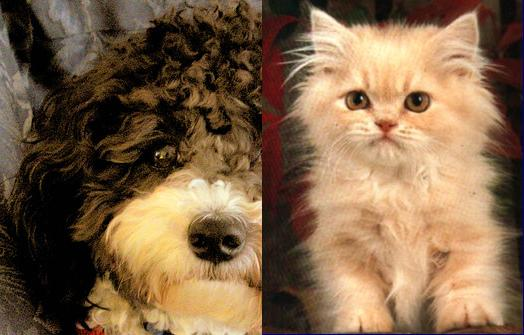

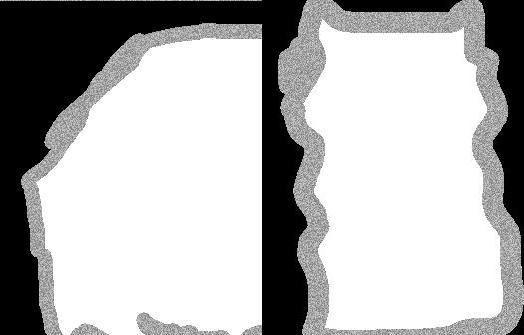

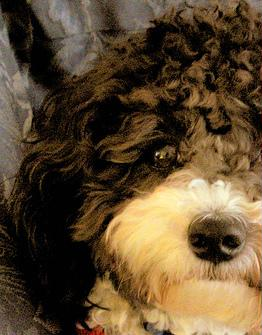

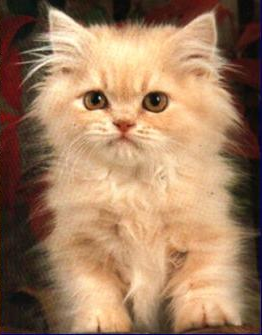

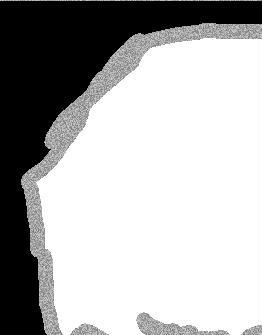

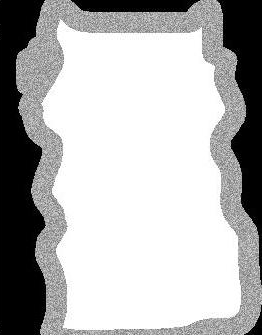

In [184]:
ids_train, breeds_train = split_two_pet_images(df_train_two_pet)
ids_val, breeds_val = split_two_pet_images(df_val_two_pet)
ids_test, breeds_test = split_two_pet_images(df_test_two_pet)

In [179]:
print(len(ids_train))
print(len(ids_val))
print(len(ids_test))

3120
282
74


In [185]:
df_train_two_pets = pd.DataFrame({'id': ids_train, 'breed_label':breeds_train})
df_val_two_pets = pd.DataFrame({'id': ids_val, 'breed_label':breeds_val})
df_test_two_pets = pd.DataFrame({'id': ids_test, 'breed_label':breeds_test})
df_test_two_pets.head()

,id,breed_label
0,dd92d14a-345a-5cee-955d-0a5992ea1f71/image_l.jpg,[1]
1,dd92d14a-345a-5cee-955d-0a5992ea1f71/image_r.jpg,[23]
2,6de3be9a-8aa8-5cf5-ac89-809508ae9a03/image_l.jpg,[0]
3,6de3be9a-8aa8-5cf5-ac89-809508ae9a03/image_r.jpg,[24]
4,673d08d9-d203-55e9-a487-31725bd0c856/image_l.jpg,[2]


In [ ]:
columns_to_drop = ['pet_id', 'label'] 
df_train_one_pet = df_train_one_pet.drop(columns=columns_to_drop)
df_val_one_pet = df_val_one_pet.drop(columns=columns_to_drop)
df_test_one_pet = df_test_one_pet.drop(columns=columns_to_drop)


In [187]:
df_test_one_pet.head()

,id,breed_label
539,2202c98d-3950-5138-9724-0175c63ba4c6,[5]
3364,8eac65ff-3695-56d4-b233-e8fd7f3275f8,[5]
4769,3f1eaf17-25cb-5a77-8b38-c08ff7bf2efb,[16]
7133,84982479-4c5c-5c2b-98b3-e09c7c6fa79f,[14]
176,4f8a373d-026f-5bed-b9b0-404e9485d281,[21]


In [191]:
string_to_add = '/image.jpg'
df_train_one_pet['id'] = df_train_one_pet['id'] + string_to_add
df_val_one_pet['id'] = df_val_one_pet['id'] + string_to_add
df_test_one_pet['id'] = df_test_one_pet['id'] + string_to_add

In [200]:
df_test_one_pet.head()

,id,breed_label
539,2202c98d-3950-5138-9724-0175c63ba4c6/image.jpg,[5]
3364,8eac65ff-3695-56d4-b233-e8fd7f3275f8/image.jpg,[5]
4769,3f1eaf17-25cb-5a77-8b38-c08ff7bf2efb/image.jpg,[16]
7133,84982479-4c5c-5c2b-98b3-e09c7c6fa79f/image.jpg,[14]
176,4f8a373d-026f-5bed-b9b0-404e9485d281/image.jpg,[21]


In [202]:
# Concatenate the dataframes vertically
df_refined_train = pd.concat([df_train_one_pet, df_train_two_pets])
# Reset the index
df_refined_train = df_refined_train.reset_index(drop=True)
df_refined_train

,id,breed_label
0,0c2aa3f7-699f-59e1-b43d-4d0a1ccf8a0d/image.jpg,[11]
1,cf344b7a-5593-5a8b-9155-2481b2fe813a/image.jpg,[34]
2,6cafc3ba-77d4-59bf-ab54-2a00a8adeffc/image.jpg,[17]
3,43879ab3-c4f3-5713-8176-9bcf800eb591/image.jpg,[25]
4,df4d8366-819b-5f76-a2aa-12f01bbf6709/image.jpg,[23]
...,...,...
9733,8f71d3e3-15d6-592c-8c7b-4b82d99e32ab/image_r.jpg,[36]
9734,ddd4889c-16b6-5c94-b495-eb4d8ec07197/image_l.jpg,[3]
9735,ddd4889c-16b6-5c94-b495-eb4d8ec07197/image_r.jpg,[35]
9736,d2642028-8e7f-58b8-bbd3-532d76ba8561/image_l.jpg,[10]


In [204]:
df_refined_val = pd.concat([df_val_one_pet, df_val_two_pets])
df_refined_val = df_refined_val.reset_index(drop=True)
print(df_refined_val.shape)

df_refined_test = pd.concat([df_test_one_pet, df_test_two_pets])
df_refined_test = df_refined_test.reset_index(drop=True)
print(df_refined_test.shape)

(868, 2)
(219, 2)


In [205]:
# This dataset only contaion
df_refined_train.to_csv('inputs/csv/df_refined_train.csv', index=False)
df_refined_val.to_csv('inputs/csv/df_refined_val.csv', index=False)
df_refined_test.to_csv('inputs/csv/df_refined_test.csv', index=False)

In [206]:
# Create these sets of csv files to test the model training. These are single-pet images and 
# there is no need to split and save the images. So, it would be easier to test the train.py and test.py.
# Alternatively, one can run "split_two_pet_images" function and use refined csv files to test train.py and test.py.
df_train_one_pet.to_csv('inputs/csv/df_train_for_test.csv', index=False)
df_val_one_pet.to_csv('inputs/csv/df_val_for_test.csv', index=False)
df_test_one_pet.to_csv('inputs/csv/df_test_for_test.csv', index=False)